<a href="https://colab.research.google.com/github/aabansal/TechnicalAnalysis/blob/main/TechnicalAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is designed to figure out whether or not a computer can accurately predict 1-day movements in stock prices when fed technical analysis data as features.

# Step 1: Add features to Data
Import libraries and add technical analysis features to the data

In [4]:
import numpy as np
import pandas as pd
import matplotlib as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv("/content/drive/My Drive/all_stocks_5yr.csv")
print(df.head(15))

          date   open   high    low  close    volume Name
0   2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1   2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2   2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3   2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4   2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL
5   2013-02-15  13.93  14.61  13.93  14.50  15628000  AAL
6   2013-02-19  14.33  14.56  14.08  14.26  11354400  AAL
7   2013-02-20  14.17  14.26  13.15  13.33  14725200  AAL
8   2013-02-21  13.62  13.95  12.90  13.37  11922100  AAL
9   2013-02-22  13.57  13.60  13.21  13.57   6071400  AAL
10  2013-02-25  13.60  13.76  13.00  13.02   7186400  AAL
11  2013-02-26  13.14  13.42  12.70  13.26   9419000  AAL
12  2013-02-27  13.28  13.62  13.18  13.41   7390500  AAL
13  2013-02-28  13.49  13.63  13.39  13.43   6143600  AAL
14  2013-03-01  13.37  13.95  13.32  13.61   7376800  AAL


**Adding Tomorrow's Price: Prediction Vector**

Let's now add a new column called Tommorow's Price, which will be the values that we are trying to predict. We don't know what the price will be tomorrow for dates after 2018-02-07, so we can mark the last days as "to be deleted" by setting them to -1

In [6]:
tomorrowsPrice = [np.NaN if df['date'][i] == '2013-02-08' else df['open'][i] for i in range(len(df['date']))]
tomorrowsPrice.pop(0)
tomorrowsPrice.append(np.NaN)

**Adding RSI: Technical Analysis Feature**

Now, we will add a column called RSI (Relative Strength Index). It is calculated using a 14 day exponential moving average, so the first 14 values for each Ticker will be NaN

In [7]:
# returns True if 14 data points are available to calculate RSI
def inRSIBounds(date):
  return (int(date[5:7]) >= 3 or int(date[0:4]) > 2013)

# calculate RSI
periods = 14
close_delta = df['close'].diff()

# Make two series: one for lower closes and one for higher closes
up = close_delta.clip(lower=0)
down = -1 * close_delta.clip(upper=0)

# Use exponential moving average
ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()

rsi = ma_up / ma_down
rsi = 100 - (100/(1 + rsi))

# set first 14 values of each ticker to NaN
rsi = [np.NaN if not inRSIBounds(df['date'][i]) else rsi[i] for i in range(len(df['date']))]

In [8]:
# Check if correct values are NaN
print(rsi[0:15])
print(rsi[1258:1274])

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 41.08754444605151]
[42.05021342774919, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 52.14422432019843]


**Adding Bollinger Bands: Technical Analysis Feature**

Let's add another three columns for bollinger bands, a common tool used in technical analysis. For the middle band, we will use a 20 day simple moving average. We will not have data for the first 20 days of each ticker, so we can mark them using NaN

In [9]:
typicalPrice = df['high'] + df['low'] + df['close']
SMA = typicalPrice.rolling(window=20).mean()
stdDev = typicalPrice.rolling(window=20).std()

# returns True if 20 data points are available to calculate a sma
def inBBBounds(date):
  return (int(date[5:7]) >= 3 and int(date[8:]) >= 8 or int(date[5:7]) >= 4 or int(date[0:4]) > 2013)

SMA = [np.NaN if (not inBBBounds(df['date'][i])) else SMA[i] for i in range(len(df['date']))]
BOLU = [np.NaN if not inBBBounds(df['date'][i]) else SMA[i] + 2*stdDev[i] for i in range(len(df['date']))]
BOLD = [np.NaN if not inBBBounds(df['date'][i]) else SMA[i] - 2*stdDev[i] for i in range(len(df['date']))]

In [10]:
# check if correct values are NaN
print(SMA[0:20])
print(SMA[1258:1279])
print(BOLU[0:20])
print(BOLU[1258:1279])
print(BOLD[0:20])
print(BOLD[1258:1279])

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 42.0505]
[164.372775, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 192.55854]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 45.537332222428894]
[180.9791027174841, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 207.4119456460399]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 38.563667777571105]
[147.76644728251588, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 177.7051343539601]


**Adding Features to Dataset**

Now that we have created the features, let's add them to the dataset and drop the NaN rows

In [11]:
df['tomorrow_open'] = tomorrowsPrice
df['RSI'] = rsi
df['SMA'] = SMA
df['BOLU'] = BOLU
df['BOLD'] = BOLD
print(list(df.columns))

['date', 'open', 'high', 'low', 'close', 'volume', 'Name', 'tomorrow_open', 'RSI', 'SMA', 'BOLU', 'BOLD']


In [12]:
df = df.dropna()
print(df.head(5))

          date   open   high    low  close    volume Name  tomorrow_open  \
19  2013-03-08  14.99  15.20  14.84  14.92  10593700  AAL          14.85   
20  2013-03-11  14.85  15.15  14.71  15.13   6961800  AAL          15.14   
21  2013-03-12  15.14  15.60  14.95  15.50   8999100  AAL          15.54   
22  2013-03-13  15.54  16.20  15.48  15.91  11380000  AAL          15.98   
23  2013-03-14  15.98  16.36  15.93  16.25   8383300  AAL          16.45   

          RSI      SMA       BOLU       BOLD  
19  63.044243  42.0505  45.537332  38.563668  
20  65.638920  42.0750  45.640304  38.509696  
21  69.678358  42.1910  46.115862  38.266138  
22  73.408790  42.4265  47.031688  37.821312  
23  76.041188  42.6610  47.991855  37.330145  


# Step 2: Split data into train/validate/test and train models on data

Now, we have created our features vectors and our predictions vector. The next step is to split the data into train, validate, and test. 
One way to do this is to shuffle the data randomly, then split it into 10% test, 70% train and 20% validate.


---
Next, we will train the following models on the data

*   Ridge Regression
*   Lasso Regression
*   





In [13]:
random_df = df.sample(frac=1)
random_df = random_df.drop(labels=["date", "Name"], axis=1)
print(random_df.head())

            open      high      low     close   volume  tomorrow_open  \
234767   75.1200   75.5000   74.510   75.3800  2242699        74.9100   
321555   47.0600   48.7500   46.100   48.2600  2463963        49.3500   
340318   43.1961   43.1961   42.098   42.7255  3623690        43.0588   
461946  113.1200  115.3449  112.465  114.9400  2075872       115.1150   
616588   26.9000   27.2900   26.770   26.9700  2332916        26.8800   

              RSI         SMA        BOLU        BOLD  
234767  87.180820  197.014580  233.012953  161.016207  
321555  46.999265  150.045620  158.989983  141.101257  
340318  45.514344  128.622870  134.610067  122.635673  
461946  60.904799  339.333370  353.769513  324.897227  
616588  61.516198   75.051305   81.657791   68.444819  


In [14]:
train, validate, test = np.split(random_df, [int(.6*len(df)), int(.8*len(df))])

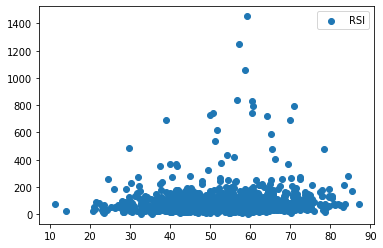

In [15]:
# plt.pyplot.scatter(train['volume'], train['tomorrow_open'], label='volume')
# plt.pyplot.scatter(train['open'], train['tomorrow_open'], label='open')
# plt.pyplot.scatter(train['low'], train['tomorrow_open'], label='low')
plt.pyplot.scatter(train['RSI'][0:1239], train['tomorrow_open'][0:1239], label='RSI')
# plt.pyplot.plot(train['SMA'], train['tomorrow_open'], label='SMA')
# plt.pyplot.plot(train['BOLU'], train['tomorrow_open'], label='BOLU')
# plt.pyplot.plot(train['BOLD'], train['tomorrow_open'], label='BOLD')
# plt.pyplot.plot(train['close'], train['tomorrow_open'], label='close')

plt.pyplot.legend()
plt.pyplot.show()

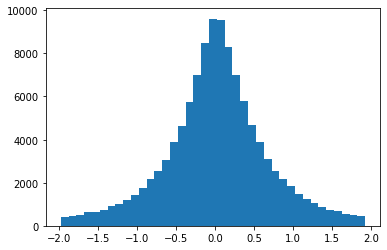

Mean of sample is 0.025934539263149287 and standard deviation is 1.5330908267039507
Variance of data is 2.350367482923803


In [16]:
closeOpenDiff = test['close'] - test['open']
_mu, _sigma = np.mean(closeOpenDiff), np.std(closeOpenDiff)

plt.pyplot.hist(closeOpenDiff, bins=[0.1*i + _mu for i in range(-20, 20)])
plt.pyplot.show()

print(f"Mean of sample is {_mu} and standard deviation is {_sigma}")
print(f"Variance of data is {_sigma ** 2}")

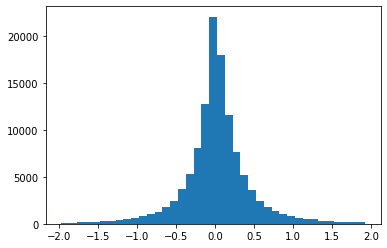

Mean of sample is 0.02352092393534094 and standard deviation is 1.2005622300082817
Variance of data is 1.4413496681224582


In [17]:
overnightDiff = test['tomorrow_open'] - test['close']
_mu, _sigma = np.mean(overnightDiff), np.std(overnightDiff)

plt.pyplot.hist(overnightDiff, bins=[0.1*i + _mu for i in range(-20, 20)])
plt.pyplot.show()

print(f"Mean of sample is {_mu} and standard deviation is {_sigma}")
print(f"Variance of data is {_sigma ** 2}")

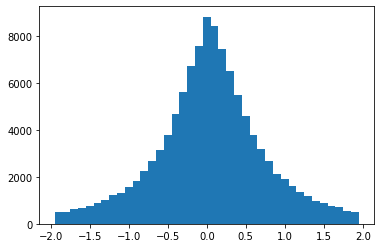

Mean of sample is 0.04945546319849022 and standard deviation is 1.9917732253515592
Variance of data is 3.967160581227353


In [18]:
openOpenDiff = test['tomorrow_open'] - test['open']
_mu, _sigma = np.mean(openOpenDiff), np.std(openOpenDiff)

plt.pyplot.hist(openOpenDiff, bins=[0.1*i + _mu for i in range(-20, 20)])
plt.pyplot.show()

print(f"Mean of sample is {_mu} and standard deviation is {_sigma}")
print(f"Variance of data is {_sigma ** 2}")

# Step 2: Train some models on the data
Now that we have our data cleaned up and ready to use, we can train a couple different models on the data in order to see which one performs the best at predicting tomorrow's opening price. To do this, we will train the following models